# Proyecto: Análisis de mercado inmobiliario 2da parte

El objetivo de este proyecto es que partiendo de la transformación de datos se entrenen Modelos Avanzados para generar un modelo que tenga un mejor desempeño que el del proyecto anterior prediciendo el precio de la propiedad. 




PARTE A - Transformación de Datos

Elige cuáles de las siguientes tareas son apropiadas para su dataset. Implementa las transformaciones que elegiste. Es importante que justifiques por qué las haces:

Detección y eliminación de Outliers
Encoding
Imputación de valores faltantes
Escalado de datos
Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA).
Vuelve a entrenar el modelo implementado en la Entrega 01 - en particular, el árbol de decisión - con este nuevo dataset transformado. Evalúa su desempeño a partir del dataset obtenido luego de transformar los datos. ¿Hay una mejora en su desempeño? Compara con el desempeño obtenido en el proyecto 01. Sea cual sea la respuesta, intenta explicar a qué se debe.

PARTE B - Modelos Avanzados

Elige dos de los modelos avanzados vistos Compara con el desempeño obtenido en el proyecto 01 (en el caso de regresión, considera una regresión lineal con atributos polinómicos y regularización). Entrénalos y evalúalos con sus argumentos por defecto. No te olvides de hacer un train/test split y usar Validación Cruzada.
Optimiza sus hiperparámetros mediante Validación Cruzada y Grid Search o Random Search.
Compara el desempeño de los nuevos modelos entre sí y con el modelo de la Parte A. ¿Cuál elegirías? Justifica.

Volveremos a cargar el dataset de Properati, realizamos el último filtrado que utilizamos en el primer proyecto para la creación de los modelos anteriores pero esta vez dejamos algunos atributos extra como los tipos de propiedades y la ubicación. 

In [5]:
import pandas as pd
import scipy as sp
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
properati = pd.read_csv('/content/drive/MyDrive/Data Science/Proyecto 1/DS_Proyecto_01_Datos_Properati.csv')

In [8]:
#Filtramos por región y tipo de propiedad con más instancias
properati = properati[(properati["l2"] == "Capital Federal") & (properati.property_type.isin(["Departamento", "Casa", "PH"]))]
#Filtramos los atrubutos con los que vamos a trabajar
properati =  properati[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price', 'property_type','l3']]
#Determinamos los rangos de algunos atributos
properati = properati.drop(properati[(properati['surface_total'] < 15.000000)].index)
properati = properati.drop(properati[(properati['surface_total'] > 1000.000000)].index)
properati = properati.drop(properati[(properati['price'] >  4000000.0)].index)
#Eliminamos instancias en las cuales superficie cubierta sea mayor a superficie total 
properati = properati.drop(properati[(properati['surface_covered'] > properati['surface_total'])].index)
properati.shape

(90538, 8)

**Detección de outliers**

Text(0.5, 0, 'Cantidad')

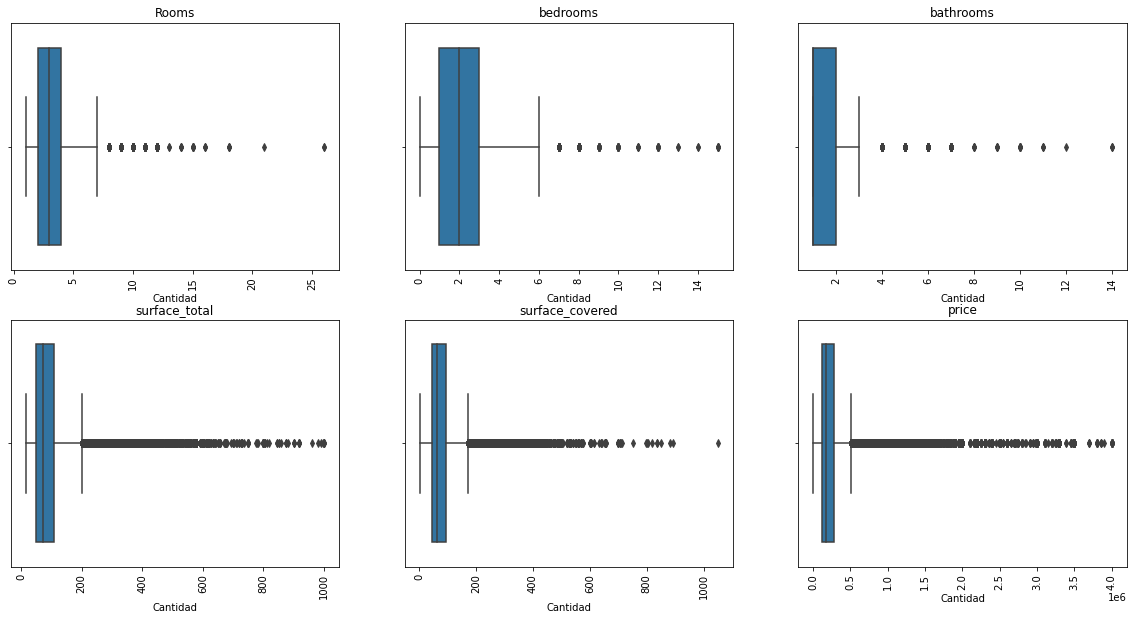

In [9]:
#Representación grafica para detectar outliers
plt.figure(figsize=(20,10))

plt.subplot(231) 
sns.boxplot(data = properati, x = 'rooms')
plt.xticks(rotation=90)
plt.title('Rooms')
plt.xlabel('Cantidad')

plt.subplot(232)
sns.boxplot(data = properati, x = 'bedrooms')
plt.xticks(rotation=90)
plt.title('bedrooms')
plt.xlabel('Cantidad')


plt.subplot(233)
sns.boxplot(data = properati, x = 'bathrooms')
plt.xticks(rotation=90)
plt.title('bathrooms')
plt.xlabel('Cantidad')


plt.subplot(234)
sns.boxplot(data = properati, x = 'surface_total')
plt.xticks(rotation=90)
plt.title('surface_total')
plt.xlabel('Cantidad')


plt.subplot(235)
sns.boxplot(data = properati, x = 'surface_covered')
plt.xticks(rotation=90)
plt.title('surface_covered')
plt.xlabel('Cantidad')


plt.subplot(236)
sns.boxplot(data = properati, x = 'price')
plt.xticks(rotation=90)
plt.title('price')
plt.xlabel('Cantidad')

A pesar de que al comienzo realizamos un filtrado de valores atipicos, podemos ver en el grafico que seguimos con bastantes outliers principalmente en surface total y surface covered asi que vamos a proceder a eliminarlos.

In [10]:
#Obtenemos estadisticos para tener una primera idea de los valores que abarcan estas variables.
properati.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,90538.000000,90538.000000,88379.000000,81622.000000,81304.000000,9.053800e+04
mean,2.960017,1.957156,1.559205,95.241111,81.944824,2.576731e+05
std,1.302350,1.066583,0.856101,77.148408,61.583765,2.901689e+05
min,1.000000,0.000000,1.000000,15.000000,1.000000,6.000000e+03
25%,2.000000,1.000000,1.000000,49.000000,44.000000,1.220000e+05
50%,3.000000,2.000000,1.000000,71.000000,63.000000,1.750000e+05
75%,4.000000,3.000000,2.000000,110.000000,95.000000,2.787000e+05
max,26.000000,15.000000,14.000000,1000.000000,1050.000000,4.000000e+06


Efectivamente la desviación estándar de las variables mencionadas anteriormente es muy alta. 

Utilizamos regla de tres sigmas determinando nuestro umbral superior e inferior para saber cuales son los valores que van a ser considerados atípicos. 

In [11]:
valor_medio = properati.mean()
std = properati.std()
minimo = valor_medio - 3*std
maximo = valor_medio + 3*std
mascara_outliers = np.logical_or(properati < minimo, properati > maximo)
properati.shape

(90538, 8)

In [12]:
mascara_outliers.sum()

bathrooms           888
bedrooms            558
l3                    0
price              1981
property_type         0
rooms              1300
surface_covered    1833
surface_total      1839
dtype: int64

A continuación vamos a eliminar por columna los valores que estan fuera de los umbrales obtenidos con regla de tres sigmas exceptuando nuestra variable objetivo. 

In [13]:
# Eliminamos los valores atípicos de rooms
valor_medio = properati.rooms.mean()
std = properati.rooms.std()
minimo = valor_medio - 3*std
maximo = valor_medio + 3*std
properati = properati.drop(properati[(properati['rooms'] < minimo)].index)
properati = properati.drop(properati[(properati['rooms'] > maximo)].index)

In [14]:
# Eliminamos los valores atípicos de bedrooms
valor_medio = properati.bedrooms.mean()
std = properati.bedrooms.std()
minimo = valor_medio - 3*std
maximo = valor_medio + 3*std
properati = properati.drop(properati[(properati['bedrooms'] < minimo)].index)
properati = properati.drop(properati[(properati['bedrooms'] > maximo)].index)

In [15]:
# Eliminamos los valores atípicos de bathrooms
valor_medio = properati.bathrooms.mean()
std = properati.bathrooms.std()
minimo = valor_medio - 3*std
maximo = valor_medio + 3*std
properati = properati.drop(properati[(properati['bathrooms'] < minimo)].index)
properati = properati.drop(properati[(properati['bathrooms'] > maximo)].index)

In [16]:
# Eliminamos los valores atípicos de surface_covered
valor_medio = properati.surface_covered.mean()
std = properati.surface_covered.std()
minimo = valor_medio - 3*std
maximo = valor_medio + 3*std
properati = properati.drop(properati[(properati['surface_covered'] < minimo)].index)
properati = properati.drop(properati[(properati['surface_covered'] > maximo)].index)

In [17]:
# Eliminamos los valores atípicos de surface_total
valor_medio = properati.surface_total.mean()
std = properati.surface_total.std()
minimo = valor_medio - 3*std
maximo = valor_medio + 3*std
properati = properati.drop(properati[(properati['surface_total'] < minimo)].index)
properati = properati.drop(properati[(properati['surface_total'] > maximo)].index)

In [18]:
#Obtenemos estadisticos post eliminacion de outliers.
properati.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,83418.000000,83418.000000,81345.000000,74938.000000,74635.000000,8.341800e+04
mean,2.760603,1.802884,1.412207,78.278857,68.828298,2.100318e+05
std,1.046466,0.888930,0.621413,41.158387,34.880476,1.547669e+05
min,1.000000,0.000000,1.000000,15.000000,1.000000,6.000000e+03
25%,2.000000,1.000000,1.000000,48.000000,43.000000,1.190000e+05
50%,3.000000,2.000000,1.000000,67.000000,60.000000,1.675000e+05
75%,3.000000,2.000000,2.000000,98.000000,84.000000,2.500000e+05
max,6.000000,4.000000,3.000000,233.000000,215.000000,3.249900e+06


Podemos observar que la desviación estándar se redujo notablemente, esto nos va a permitir contar con datos uniformes y representativos. 

Text(0.5, 0, 'Cantidad')

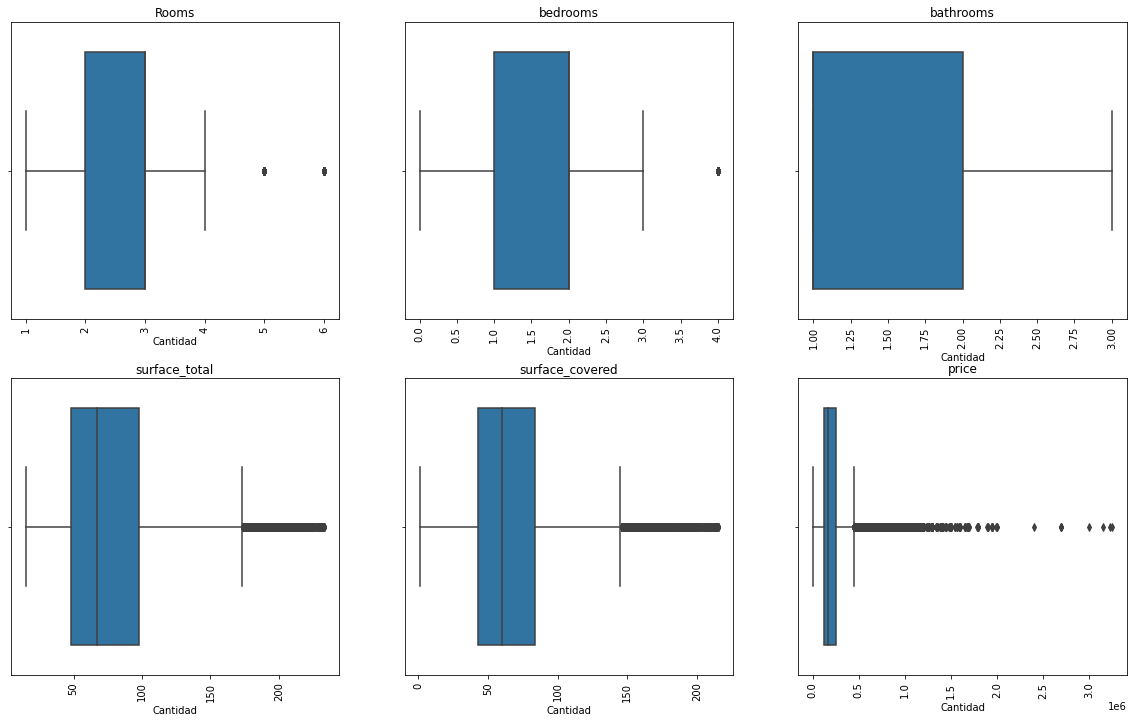

In [19]:
#Representación grafica post eliminacion de outliers
plt.figure(figsize=(20,12))

plt.subplot(231) 
sns.boxplot(data = properati, x = 'rooms')
plt.xticks(rotation=90)
plt.title('Rooms')
plt.xlabel('Cantidad')

plt.subplot(232)
sns.boxplot(data = properati, x = 'bedrooms')
plt.xticks(rotation=90)
plt.title('bedrooms')
plt.xlabel('Cantidad')


plt.subplot(233)
sns.boxplot(data = properati, x = 'bathrooms')
plt.xticks(rotation=90)
plt.title('bathrooms')
plt.xlabel('Cantidad')


plt.subplot(234)
sns.boxplot(data = properati, x = 'surface_total')
plt.xticks(rotation=90)
plt.title('surface_total')
plt.xlabel('Cantidad')


plt.subplot(235)
sns.boxplot(data = properati, x = 'surface_covered')
plt.xticks(rotation=90)
plt.title('surface_covered')
plt.xlabel('Cantidad')


plt.subplot(236)
sns.boxplot(data = properati, x = 'price')
plt.xticks(rotation=90)
plt.title('price')
plt.xlabel('Cantidad')

Como podemos visualizar se redujo notablemente la cantidad de valores atípicos. 

**Valores faltantes**

Vamos a tratar de encontrar el motivo de los valores faltantes y si alguno de ellos está correlacionado con alguna variable.

In [20]:
# Obtenemos la cantidad de valores faltantes
properati.isnull().sum()

rooms                 0
bedrooms              0
bathrooms          2073
surface_total      8480
surface_covered    8783
price                 0
property_type         0
l3                    0
dtype: int64

In [21]:
properati.shape

(83418, 8)

In [22]:
# Visualizamos la correlación de atributos con valores faltantes 
properati.corr()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
rooms,1.000000,0.938724,0.551656,0.747825,0.780768,0.503176
bedrooms,0.938724,1.000000,0.553476,0.730543,0.766468,0.487249
bathrooms,0.551656,0.553476,1.000000,0.625065,0.656443,0.609320
surface_total,0.747825,0.730543,0.625065,1.000000,0.928242,0.698404
surface_covered,0.780768,0.766468,0.656443,0.928242,1.000000,0.739223
price,0.503176,0.487249,0.609320,0.698404,0.739223,1.000000


Por un lado podemos ver que bathrooms tiene una correlación similar con todos los atributos y por otro surface total y surface covered estan altamente correlacionadas entre si.

Con el siguiente gráfico vamos a corroborar si encontramos correlación entre bathrooms y las variables categóricas.

In [23]:
# Obtenemos los valores faltantes
nulos = properati[properati['bathrooms'].isnull()]

Text(0, 0.5, 'property_type')

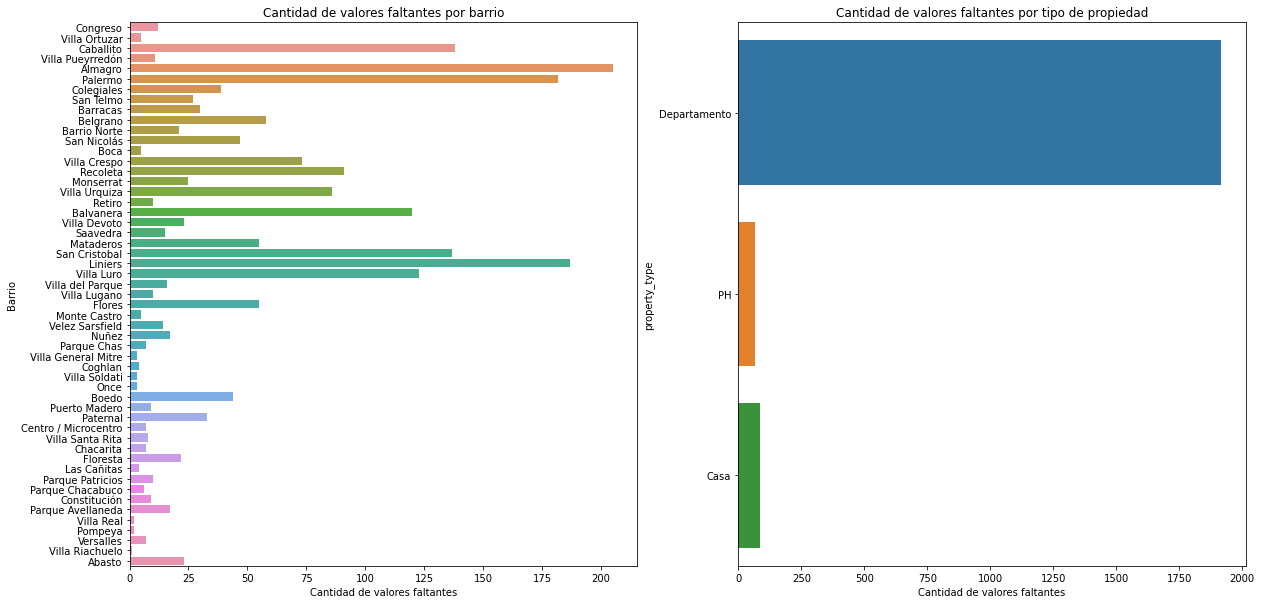

In [24]:
plt.figure(figsize=(20,10))

plt.subplot(121) 
sns.countplot(y = nulos['l3'])
plt.title('Cantidad de valores faltantes por barrio')
plt.xlabel('Cantidad de valores faltantes')
plt.ylabel('Barrio')

plt.subplot(122)
sns.countplot(y = nulos['property_type'])
plt.title('Cantidad de valores faltantes por tipo de propiedad')
plt.xlabel('Cantidad de valores faltantes')
plt.ylabel('property_type')

Al visualizar que la gran mayoría de valores faltantes se encuentran en el tipo de propiedad "departamento" vamos a asignarle el promedio de baños que tienen los mismos.


In [25]:
# Calculamos el promedio de los baños que tienen los departamentos 
mean_depto = properati[['property_type', 'bathrooms']][properati.property_type.isin(["Departamento"])].mean()
# Reemplazamos cada valor faltante con ese promedio
properati.fillna(mean_depto, inplace = True)
# Notamos que ya no tenemos faltantes en bathrooms
properati.isna().sum()

rooms                 0
bedrooms              0
bathrooms             0
surface_total      8480
surface_covered    8783
price                 0
property_type         0
l3                    0
dtype: int64

In [26]:
nulos = properati[properati['surface_total'].isnull()]
nulos2 = nulos[nulos['surface_covered'].isnull()]
nulos2

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,l3
4302,1.0,1.0,1.0,NaN,NaN,56000.0,Departamento,Floresta
4446,3.0,2.0,2.0,NaN,NaN,180000.0,Departamento,Floresta
7360,4.0,3.0,2.0,NaN,NaN,210000.0,PH,Villa Real
9185,3.0,2.0,2.0,NaN,NaN,126000.0,Departamento,Pompeya
10278,1.0,0.0,1.0,NaN,NaN,109000.0,Departamento,Caballito
...,...,...,...,...,...,...,...,...
145390,1.0,0.0,1.0,NaN,NaN,125000.0,Departamento,Belgrano
145424,2.0,1.0,1.0,NaN,NaN,125000.0,Departamento,Belgrano
145425,1.0,1.0,1.0,NaN,NaN,125000.0,Departamento,Belgrano
145427,2.0,1.0,1.0,NaN,NaN,125000.0,Departamento,Belgrano


Con esta información sabemos que el 50% de las instancias con valores faltantes no tienen valores tanto en surface total como en surface covered es por eso que no podemos aplicar un método de imputación según su correlación, simplemente los completamos con el promedio de cada atributo. 

In [27]:
# Reemplazamos cada valor faltante con el promedio del atributo superficie total 
mean_surface_total = properati[['surface_total']].mean()
properati.fillna(mean_surface_total, inplace = True)
# Notamos que ya no tenemos faltantes en surface total
properati.isna().sum()

rooms                 0
bedrooms              0
bathrooms             0
surface_total         0
surface_covered    8783
price                 0
property_type         0
l3                    0
dtype: int64

In [28]:
# Reemplazamos cada valor faltante con el promedio del atributo menos dos desviaciones standar 
# para que no sean menores que superficie cubierta.
mean_surface_covered = properati[['surface_covered']].mean()
std = properati.surface_covered.std()
mean1std = mean_surface_covered - 2*std
properati.fillna(mean1std, inplace = True)
# Notamos que ya no tenemos faltantes en surface covered
properati.isna().sum()

rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
property_type      0
l3                 0
dtype: int64

Finalmente, dentro de nuestra imputación, debemos corroborar que no haya valores de Superficie Total menor a Superficie Cubierta ya que eso no tendría sentido.

In [29]:
properati[properati.surface_total < properati.surface_covered]

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,l3
23228,4.0,3.0,2.000000,78.278857,92.0,145000.0,Departamento,Constitución
23284,5.0,3.0,1.000000,78.278857,130.0,100000.0,Casa,Monserrat
30978,4.0,3.0,2.000000,78.278857,120.0,280000.0,Casa,Floresta
33056,5.0,4.0,1.405369,78.278857,190.0,230000.0,Casa,Floresta
38944,4.0,3.0,2.000000,78.278857,110.0,280000.0,Departamento,Recoleta
46741,4.0,3.0,3.000000,78.278857,137.0,260000.0,Casa,Las Cañitas
48320,4.0,3.0,2.000000,78.278857,167.0,250000.0,Departamento,Parque Patricios
49565,4.0,3.0,2.000000,78.278857,88.0,138000.0,Departamento,Floresta
52284,4.0,3.0,2.000000,78.278857,120.0,290000.0,Casa,Floresta
65662,3.0,2.0,2.000000,78.278857,79.0,165000.0,Departamento,Boedo


In [30]:
# Al ser muy poquitos en base a la cantidad de nuestros datos vamos a eliminarlos para que nuestro dataset no quede con datos irracionales. 
properati = properati.drop(properati[(properati.surface_total < properati.surface_covered)].index)
# Corroboramos que ya no estan 
properati[properati.surface_total < properati.surface_covered]

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,l3


**Escalado**

Decidí no utilizar escalado ya que no solo no mejora el desempeño del modelo, sino que tambien los estadisticos empeoran.

**Codificacón**

Como nuestras variables categoricas son nominales utilizaremos One-Hot Encoding para asignarles un valor a cada una de ellas.

In [31]:
# Obtenemos one hot encoding de la columna property_type
one_hot = pd.get_dummies(properati.property_type)
# Eliminamos la columna property_type
properati = properati.drop('property_type',axis = 1)
# Unimos 
properati = pd.concat([properati, one_hot], axis=1)
properati

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,l3,Casa,Departamento,PH
1,2.0,1.0,2.0,70.0,58.0,159000.0,Boedo,0,0,1
2,2.0,1.0,1.0,45.0,45.0,125000.0,Palermo,0,0,1
3,2.0,1.0,1.0,85.0,50.0,295000.0,Palermo,0,0,1
5,2.0,1.0,1.0,56.0,56.0,150000.0,Villa Crespo,0,0,1
6,2.0,1.0,1.0,70.0,70.0,159500.0,Villa Crespo,0,0,1
...,...,...,...,...,...,...,...,...,...,...
146552,4.0,2.0,3.0,159.0,98.0,539000.0,Palermo,0,1,0
146553,4.0,3.0,2.0,106.0,100.0,620000.0,Palermo,0,1,0
146554,4.0,3.0,3.0,175.0,111.0,570000.0,Palermo,0,0,1
146555,3.0,2.0,2.0,144.0,134.0,480000.0,Palermo,0,0,1


In [32]:
# Obtenemos one hot encoding de la columna l3
one_hot = pd.get_dummies(properati.l3)
# Eliminamos la columna property_type
properati = properati.drop('l3',axis = 1)
# Unimos 
properati = pd.concat([properati, one_hot], axis=1)
properati

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Casa,Departamento,PH,Abasto,Agronomía,Almagro,Balvanera,Barracas,Barrio Norte,Belgrano,Boca,Boedo,Caballito,Catalinas,Centro / Microcentro,Chacarita,Coghlan,Colegiales,Congreso,Constitución,Flores,Floresta,Las Cañitas,Liniers,Mataderos,Monserrat,Monte Castro,Nuñez,Once,Palermo,Parque Avellaneda,Parque Centenario,Parque Chacabuco,Parque Chas,Parque Patricios,Paternal,Pompeya,Puerto Madero,Recoleta,Retiro,Saavedra,San Cristobal,San Nicolás,San Telmo,Tribunales,Velez Sarsfield,Versalles,Villa Crespo,Villa Devoto,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque
1,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,2.0,1.0,1.0,70.0,70.0,159500.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146552,4.0,2.0,3.0,159.0,98.0,539000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
146553,4.0,3.0,2.0,106.0,100.0,620000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
146554,4.0,3.0,3.0,175.0,111.0,570000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
146555,3.0,2.0,2.0,144.0,134.0,480000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Al haber realizado encoding para los atributos l3 y property_type nuestro modelo tambien puede predecir utilizando como información tipos de propiedades y los diferentes barrios. 

In [33]:
#Obtenemos estadisticos post preprocesamiento.
properati.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Casa,Departamento,PH,Abasto,Agronomía,Almagro,Balvanera,Barracas,Barrio Norte,Belgrano,Boca,Boedo,Caballito,Catalinas,Centro / Microcentro,Chacarita,Coghlan,Colegiales,Congreso,Constitución,Flores,Floresta,Las Cañitas,Liniers,Mataderos,Monserrat,Monte Castro,Nuñez,Once,Palermo,Parque Avellaneda,Parque Centenario,Parque Chacabuco,Parque Chas,Parque Patricios,Paternal,Pompeya,Puerto Madero,Recoleta,Retiro,Saavedra,San Cristobal,San Nicolás,San Telmo,Tribunales,Velez Sarsfield,Versalles,Villa Crespo,Villa Devoto,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque
count,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,8.339000e+04,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.00000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000,83390.000000
mean,2.760199,1.802494,1.411938,78.278857,61.464294,2.100205e+05,0.015074,0.885010,0.099916,0.005288,0.001775,0.085754,0.03299,0.007963,0.034968,0.071951,0.003538,0.010193,0.072275,0.000060,0.005672,0.008574,0.006643,0.017892,0.007447,0.005264,0.027485,0.009905,0.007807,0.011596,0.007783,0.009090,0.007063,0.021417,0.008238,0.142247,0.002722,0.015002,0.008610,0.003322,0.005061,0.011512,0.002075,0.014774,0.060115,0.008502,0.012591,0.017388,0.009162,0.011476,0.001955,0.002051,0.002350,0.074385,0.014558,0.004617,0.005061,0.010673,0.003538,0.007891,0.001571,0.000432,0.003897,0.000564,0.038278,0.014990
std,1.046335,0.888764,0.613632,39.016842,39.318969,1.547795e+05,0.121847,0.319012,0.299890,0.072529,0.042091,0.280002,0.17861,0.088878,0.183700,0.258408,0.059373,0.100445,0.258944,0.007743,0.075100,0.092200,0.081237,0.132559,0.085974,0.072366,0.163494,0.099032,0.088010,0.107060,0.087876,0.094907,0.083746,0.144772,0.090392,0.349306,0.052103,0.121560,0.092391,0.057539,0.070958,0.106676,0.045501,0.120648,0.237701,0.091815,0.111504,0.130714,0.095278,0.106511,0.044169,0.045237,0.048424,0.262399,0.119776,0.067791,0.070958,0.102757,0.059373,0.088479,0.039604,0.020773,0.062307,0.023734,0.191868,0.121513
min,1.000000,0.000000,1.000000,15.000000,-0.932654,6.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,50.000000,39.000000,1.190000e+05,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [34]:
properati.corr()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Casa,Departamento,PH,Abasto,Agronomía,Almagro,Balvanera,Barracas,Barrio Norte,Belgrano,Boca,Boedo,Caballito,Catalinas,Centro / Microcentro,Chacarita,Coghlan,Colegiales,Congreso,Constitución,Flores,Floresta,Las Cañitas,Liniers,Mataderos,Monserrat,Monte Castro,Nuñez,Once,Palermo,Parque Avellaneda,Parque Centenario,Parque Chacabuco,Parque Chas,Parque Patricios,Paternal,Pompeya,Puerto Madero,Recoleta,Retiro,Saavedra,San Cristobal,San Nicolás,San Telmo,Tribunales,Velez Sarsfield,Versalles,Villa Crespo,Villa Devoto,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque
rooms,1.000000,0.938712,0.543166,0.697578,0.664607,0.503262,0.147903,-0.222221,0.176297,0.003911,-0.005040,0.028358,-0.018500,0.000416,0.042254,0.039287,-0.012983,-0.017819,0.012007,0.001775,-0.013670,-0.011255,-0.015399,-0.029155,-0.013608,-0.029256,0.016027,0.002786,0.011995,-0.011360,0.012342,-0.007394,-0.030211,-0.014227,0.008463,-0.007529,0.017473,0.037241,-0.007793,-0.010074,0.011015,0.001956,0.021784,-0.015633,0.067797,0.015855,-0.018112,-0.052984,-0.028604,-0.033412,0.007288,-0.004559,0.008284,-0.032868,0.018862,-0.006708,0.036858,-0.031852,-0.001401,-0.013110,-0.003063,0.008625,0.000172,0.017032,-0.042026,-0.001627
bedrooms,0.938712,1.000000,0.543202,0.667763,0.651401,0.487323,0.142990,-0.213885,0.169426,0.007088,-0.004734,0.031003,-0.018105,0.004121,0.037528,0.041304,-0.009485,-0.020434,0.018778,-0.000022,-0.015016,-0.009773,-0.018367,-0.034946,-0.014336,-0.027837,0.020441,0.000564,0.013426,-0.015125,0.014000,-0.008003,-0.028948,-0.009530,0.010999,-0.011827,0.018861,0.039857,-0.004993,-0.005696,0.013757,0.005895,0.016360,-0.015061,0.057280,0.010145,-0.018468,-0.059521,-0.022390,-0.031162,0.003419,-0.006629,0.006607,-0.033263,0.021040,-0.010143,0.041329,-0.028129,-0.002213,-0.013731,-0.003450,0.008516,0.000474,0.017216,-0.042796,-0.000790
bathrooms,0.543166,0.543202,1.000000,0.588505,0.500604,0.600888,0.073882,-0.029892,0.001779,-0.002517,-0.008342,-0.023568,-0.042409,-0.005577,0.026947,0.102693,-0.026824,-0.033330,0.026882,-0.000151,-0.016396,-0.028975,-0.007841,-0.008669,-0.020901,-0.035969,-0.000701,-0.025684,0.063606,-0.008495,0.005548,-0.028646,-0.021610,0.021756,-0.039951,0.026092,-0.001357,0.030331,-0.022705,-0.005526,-0.026380,-0.028044,-0.013510,0.139165,0.072419,0.024688,-0.016029,-0.048855,-0.035621,-0.036380,0.002148,-0.010267,-0.013682,-0.066334,-0.002899,-0.001839,-0.017016,-0.014980,-0.006417,-0.011617,-0.010931,-0.002281,-0.019332,-0.010824,-0.017218,-0.025481
surface_total,0.697578,0.667763,0.588505,1.000000,0.775910,0.654917,0.190351,-0.263340,0.202791,-0.010803,0.001098,-0.035603,-0.042815,0.010879,0.018426,0.055644,-0.017702,-0.011008,-0.008498,0.001334,-0.029150,-0.009775,-0.005431,-0.008531,-0.023770,-0.025650,0.013765,0.006586,0.030966,-0.002931,0.023292,-0.018445,-0.012397,-0.007770,-0.021124,0.005628,0.009637,0.005587,0.005239,0.005098,0.006278,-0.009540,0.031311,0.097580,0.093106,0.020626,-0.002833,-0.018161,-0.040486,-0.029629,-0.008737,0.007811,0.009101,-0.079501,0.036044,0.000717,0.011588,-0.003427,-0.004185,0.000228,0.007171,0.008116,-0.001911,0.011907,-0.024732,0.000788
surface_covered,0.664607,0.651401,0.500604,0.775910,1.000000,0.605538,0.092023,-0.200916,0.176337,-0.008710,-0.004009,-0.015926,-0.050177,0.010047,0.055590,0.040213,-0.019267,-0.028039,-0.015356,0.004044,-0.007043,-0.009838,-0.014272,-0.033961,-0.012219,-0.033047,-0.009933,-0.004409,0.014707,-0.063601,-0.021386,-0.006081,-0.023827,0.003804,-0.002625,0.052847,-0.010461,0.029908,-0.010271,-0.005478,0.003610,0.000926,0.016265,0.124778,0.125062,0.041632,-0.026570,-0.081116,-0.031681,-0.016614,0.003238,-0.015575,-0.001212,-0.037174,0.012941,-0.019014,0.005832,-0.075391,-0.018879,-0.009820,-0.003097,-0.001282,-0.011314,0.007535,-0.041136,-0.006111
...,...,...,...,...,...,...,...,...,...,...,...,...,..

##  DecisionTreeRegressor con datos preprocesados 

Vamos a realizar el mismo modelo del proyecto 1 pero con la diferencia de que ahora le ingresaremos datos preprocesados para compararlos entre si. 

In [35]:
#Seleccionamos las variables predictoras (X) y la variable a predecir (y)
X = properati.drop("price", axis=1)
y = properati.price

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

In [37]:
#Elegimos nuestra metrica de evaluación
from sklearn.metrics import mean_squared_error
#Creamos el modelo 
from sklearn.tree import DecisionTreeRegressor
tree_regressor = DecisionTreeRegressor(max_depth=10, random_state=42)

#Entrenamos
tree_regressor.fit(X_train, y_train)

#Predecimos tanto para train como para test
y_train_pred = tree_regressor.predict(X_train)
y_test_pred = tree_regressor.predict(X_test)

#Calculamos el RMSE para train, test
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

**Visualización**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


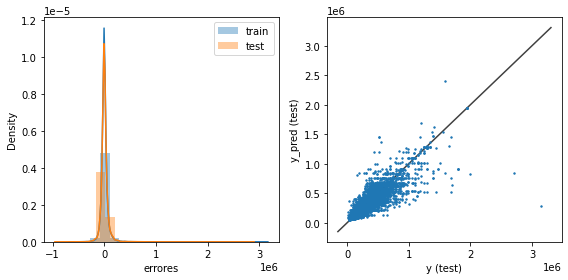

Raíz del error cuadrático medio en Train: 68893.04098947167
Raíz del error cuadrático medio en Test: 73613.4492303537


In [38]:
#En la primer instancia del subplot creamos un grafico de distribución para apreciar la diferencia de errores entre train y test
plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()

#En la segunda instancia del subplot creamos un grafico para comparar las variables pronosticadas con el valor real
ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2)

#Determinamos los limites minimos y maximos de cada eje   
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]), 
np.max([ax.get_xlim(), ax.get_ylim()]),]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
    
plt.tight_layout()
plt.show()
print('Raíz del error cuadrático medio en Train:', rmse_train)
print('Raíz del error cuadrático medio en Test:', rmse_test)

In [39]:
rmsetr_tree_preprocesado = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmsets_tree_preprocesado = np.sqrt(mean_squared_error(y_test, y_test_pred))

In [40]:
# Errores utilizando los datos sin transformación (proyecto 1):
rmse_train_P1 = 120797.5008434747
rmse_test_P1 = 152950.67757423845
errores_train = [rmse_train_P1, rmsetr_tree_preprocesado]
errores_test = [rmse_test_P1, rmsets_tree_preprocesado]
p1P2 = ['Arbol Regresor Proyecto1', 'Arbol Regresor Preprocesado']

Text(0, 0.5, 'RMSE')

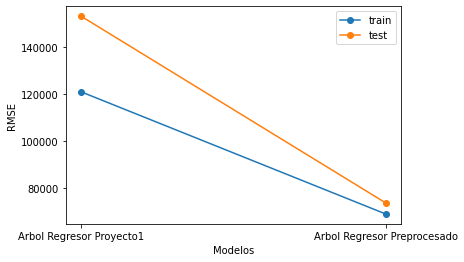

In [41]:
plt.plot(p1P2,errores_train,'o-',label='train' )
plt.plot(p1P2,errores_test,'o-',label='test')
plt.legend()
plt.xlabel('Modelos')
plt.ylabel('RMSE')

# Resultado

*No solo podemos observar que el desempeño mejoró exponencialmente sino tambien que la varianza disminuyo notablemente comparado con el mismo modelo, pero con utilización de datos preprocesados. Esto se debe, primeramente, a que pudimos darle mayor informacion con nuevos atributos gracias a la codificacón e imputación de valores faltantes.*

**Parte B**
Elegiremos modelos avanzados vistos, los compararemos con el desempeño obtenido en el proyecto 01 y luego entre sí mismos. 


In [42]:
# Chequeamos que la proporción de cada clase en las etiquetas en ambos conjuntos sea parecida
print('Proporcion de etiquetas positiva en los datos de Train: ', y_train.sum()/y_train.size)
print('Proporcion de etiquetas positiva en los datos de Test: ', y_test.sum()/y_test.size)

Proporcion de etiquetas positiva en los datos de Train:  210017.64846761344
Proporcion de etiquetas positiva en los datos de Test:  210027.11276332094


## DecisionTreeRegressor con optimización de hiperparametros 

Utilizaremos Random Search para optimizar los hiperparametros de un DecisionTreeRegressor con datos preprocesados. Al tener conocimiento previo de los datos y modelo podemos estimar determinado rango.

In [43]:
from sklearn.model_selection import RandomizedSearchCV

tree_regressor = DecisionTreeRegressor()

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

En base a lo que conocemos de nuestros datos tomamos solo un rango del 1 al 30 ya que sabemos que la mejor opcion esta dentro de esa cantidad.

In [45]:
# Grilla para Random Search
param_dist = {'criterion':['squared_error', 'mse', 'absolute_error', 'mae'],
              'max_depth': sp.stats.randint(5, 25), 
              'min_samples_split':sp.stats.randint(2, 10),
              'min_samples_leaf':sp.stats.randint(1, 10)}

Entrenamos el nuevo arbol optimizado con Random Search, utilizando validación cruzada de 5 folds. Solo haremos 25 intentos para que no tenga un gran costo computacional. 

In [46]:
model = RandomizedSearchCV(tree_regressor, param_dist,n_iter=25, random_state=0, cv=5)

# # Entrenamos: tree_regressor con la grilla definida arriba y CV con tamaño de Fold=5
# model.fit(X_train, y_train)

**Mejores paramtros segun Random Search:** {'criterion': 'mse', 'max_depth': 18, 'min_samples_leaf': 9, 'min_samples_split': 3}

In [47]:
# print(model.best_score_)
# print(model.best_params_)

In [48]:
tree_preprocesado_optimizado = DecisionTreeRegressor(criterion ='mse', max_depth = 18, min_samples_leaf = 9, min_samples_split= 3)

tree_preprocesado_optimizado.fit(X_train,y_train)

y_train_pred = tree_preprocesado_optimizado.predict(X_train)
y_test_pred = tree_preprocesado_optimizado.predict(X_test)

In [49]:
rmsetr_tree_preprocesado_optimizado = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmsets_tree_preprocesado_optimizado = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Raíz del error cuadrático medio en Train: {rmsetr_tree_preprocesado_optimizado}')
print(f'Raíz del error cuadrático medio en Test: {rmsets_tree_preprocesado_optimizado}')

Raíz del error cuadrático medio en Train: 64405.09574003094
Raíz del error cuadrático medio en Test: 70331.79275444472


# LinearRegression 
 Para el caso de regresión lineal si vamos a reescalar los datos ya que es la mejor forma de ingresarlos a este modelo en particular. Así mismo vamos a utilizar como Benchmark una regresión lineal simple. Luego agregaremos atributos polinómicos y regularización para ver cómo mejoró nuestro modelo. Nuestra métrica de evaluación final sigue siendo RMSE.


In [50]:
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge

In [51]:
# Dividimos el Dataset para escalar solo variables numericas, luego volveremos a concatenar las categoricas.
variables_a_escalar_X = X[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']]
variables_categoricas_X = X.drop(X[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']], axis=1)
variables_categoricas_X.index = np.arange(0,len(variables_categoricas_X))

In [52]:
# Escalamos
scl = StandardScaler()
variables_escaladas = scl.fit_transform(variables_a_escalar_X)

In [53]:
# Convertimos el arreglo en un DataFrame
column_names = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']
df_variables_escaladas = pd.DataFrame(variables_escaladas, columns=column_names)
# Concatenamos nuevamente las variables escaladas con las categoricas
X = pd.concat([df_variables_escaladas, variables_categoricas_X], axis = 1)

In [54]:
# Dividimos las muestras 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

**Benchmark**

Regresión lineal simple

In [55]:
# Creamos la regresión, entrenamos y predecimos.
reg_1 = LinearRegression()
reg_1.fit(X_train, y_train)
y_train_pred_1 = reg_1.predict(X_train)
y_test_pred_1 = reg_1.predict(X_test)

In [56]:
# Calculamos el error
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_1))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_1))
print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

Raíz del error cuadrático medio en Train: 89839.05222311257
Raíz del error cuadrático medio en Test: 89734.825602133


**Suma de atributos polinómicos**

Al tener una gran cantidad de instancias sólo utilizaremos un polinomio de grado 2 para que no ocupe mucho espacio y que no nos dificulte la operación.

In [57]:
# Agregamos atributos polinómicos
poly = PolynomialFeatures(2, include_bias=False)
X_train_new = poly.fit_transform(X_train)
X_test_new = poly.fit_transform(X_test)

In [58]:
# Entrenamos una nueva regresión lineal con nuevos atributos 
reg_2 = LinearRegression()
reg_2.fit(X_train_new, y_train)
# Predecimos 
y_train_pred_2 = reg_2.predict(X_train_new)
y_test_pred_2 = reg_2.predict(X_test_new)

In [125]:
variables_sin_reg = []
for i in reg_2.coef_: 
   if i == 0:
     variables_sin_reg.append(i)
len(variables_sin_reg)


1598

In [59]:
print(f'Pendientes: {reg_2.coef_}')
print(f'Ordenada: {reg_2.intercept_}')

Pendientes: [ 4.33157039e+16  1.31695132e+16  1.11732239e+14 ... -2.38020134e+12
  0.00000000e+00 -3.48672426e+12]
Ordenada: 55101795743212.29


In [60]:
# Calculamos el error 
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_2))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_2))
print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

Raíz del error cuadrático medio en Train: 75654.90501495989
Raíz del error cuadrático medio en Test: 11827391819498.465


**Regularización**

Utilizamos regularización Ridge ya que es la mejor forma cuando las variables se encuentran altamente correlacionadas. 

In [61]:
# Regulación Ridge
reg_ridge = Ridge(alpha= 0.1)
reg_ridge.fit(X_train_new,y_train)
y_train_pred_Ridge = reg_ridge.predict(X_train_new)
y_test_pred_Ridge = reg_ridge.predict(X_test_new)

In [127]:
variables_con_reg = []
for i in reg_ridge.coef_: 
   if i == 0:
     variables_con_reg.append(i)
len(variables_con_reg)

1609

In [62]:
print(f'Pendientes: {reg_ridge.coef_}')
print(f'Ordenada: {reg_ridge.intercept_}')

Pendientes: [ 1987.5056878    734.59887576  5101.75411543 ... 11482.82737424
     0.           138.9642273 ]
Ordenada: 161417.67501272622


In [63]:
rmsetr_LinearRegression = np.sqrt(mean_squared_error(y_train, y_train_pred_Ridge))
rmsets_LinearRegression = np.sqrt(mean_squared_error(y_test, y_test_pred_Ridge))
print(f'Raíz del error cuadrático medio en Train: {rmsetr_LinearRegression}')
print(f'Raíz del error cuadrático medio en Test: {rmsets_LinearRegression}')

Raíz del error cuadrático medio en Train: 75654.85110755589
Raíz del error cuadrático medio en Test: 76103.55207396283


Gracias a la suma de atributos polinomicos regularización podemos observar que tuvo una gran mejora con respecto a una regresión lineal simple. 

**Interpretación de variables**

Vemos que cuando agregamos atributos teniamos 1598 de ellos que valian 0, es decir, que el modelo no les estaba dando importancia para predecir. Al aplicar regularización ridge gran cantidad de atributos bajaron la importancia a la hora de predecir y en total 1609 fueron llevados a cero reduciendo asi el sobre ajuste y disminuyendo la varianza. Gracias a esto se pudo encontrar un equilibrio para que nuestro modelo no se encuentre sobreajustado. 

# Random Forest 

Este modelo es muy bueno para problemas de regresión, por este motivo lo consideramos importante en esta comparativa. Probando diferentes tipos de hiperparametros pudimos llegar a los que se veran a continuación y realmente dio muy buenos resultados. 

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

In [65]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators=100, max_features='sqrt', n_jobs=-1, oob_score = True, random_state = 42)
clf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=True,
                      random_state=42, verbose=0, warm_start=False)

In [66]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [67]:
# Calculamos el error 
rmsetr_RandomForest = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmsets_RandomForest = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Raíz del error cuadrático medio en Train: {rmsetr_RandomForest}')
print(f'Raíz del error cuadrático medio en Test: {rmsets_RandomForest}')

Raíz del error cuadrático medio en Train: 40685.4001776207
Raíz del error cuadrático medio en Test: 59385.84878159466


**Errores**

Con este modelo vemos que el mayor error lo tiene en los datos de prueba y la varianza entre train y test es bastante alta en comparación con los demás. Se podria decir que el modelo se encuentra algo sobreajustado. 

# XGBoost

In [68]:
import xgboost as xgb

from sklearn.model_selection import GridSearchCV

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

In [70]:
xgb1 = xgb.XGBRegressor() 

param = {'nthread':[4], 
              'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [2, 3, 4],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100]}

xgb_grid = GridSearchCV(xgb1, param, cv = 3, n_jobs = 5, verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  27 out of  27 | elapsed:  2.3min finished


0.7562282438430605
{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'nthread': 4, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 0.7}


Mejores parametros segun Grid Search: 'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'nthread': 4, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 0.7}

In [71]:
XGBoost2 = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.07, max_depth= 4,
                            min_child_weight= 4, n_estimators= 100, nthread= 4,
                            objective= 'reg:squarederror', silent= 1, subsample= 0.7) 

XGBoost2.fit(X_train,y_train)

y_train_pred = XGBoost2.predict(X_train)
y_test_pred = XGBoost2.predict(X_test)

In [72]:
# Calculamos el error 
rmsetr_XGBoost = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmsets_XGBoost = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Raíz del error cuadrático medio en Train: {rmsetr_XGBoost}')
print(f'Raíz del error cuadrático medio en Test: {rmsets_XGBoost}')

Raíz del error cuadrático medio en Train: 75697.25104312
Raíz del error cuadrático medio en Test: 75751.44386085702


**Errores**

Vemos que es un modelo que nos permite tener casi un equilibrio entre el error de train y test, quiere decir que es un modelo que si bien se equivoca en los datos de train puede predecir de una forma similar con los datos de test. 

## Comparativa de modelos

Veremos de forma clara cual es modelo con menor error, según nuestra metrica utilizada hasta ahora (rmse)

In [73]:
Historial_de_errores = {'Modelo':['Árbol Regresor Proyecto1', 'Árbol Regresor Preprocesado', 'Árbol Regresor Preprocesado y Optimizado',
                                'Random Forest', 'Regresión Lineal', 'XGBoost'],
                      'Train':[rmse_train_P1, rmsetr_tree_preprocesado, rmsetr_tree_preprocesado_optimizado,
                               rmsetr_RandomForest, rmsetr_LinearRegression, rmsetr_XGBoost],
                      'Test':[rmse_test_P1, rmsets_tree_preprocesado, rmsets_tree_preprocesado_optimizado,
                              rmsets_RandomForest, rmsets_LinearRegression, rmsets_XGBoost]}

Historial_de_errores =  pd.DataFrame(Historial_de_errores)
by_period = Historial_de_errores.sort_values('Test') #ordenar de menor a mayor 
by_period

,Modelo,Train,Test
3,Random Forest,40685.400178,59385.848782
2,Árbol Regresor Preprocesado y Optimizado,64405.095740,70331.792754
1,Árbol Regresor Preprocesado,68893.040989,73613.449230
5,XGBoost,75697.251043,75751.443861
4,Regresión Lineal,75654.851108,76103.552074
0,Árbol Regresor Proyecto1,120797.500843,152950.677574


Text(0, 0.5, 'RMSE')

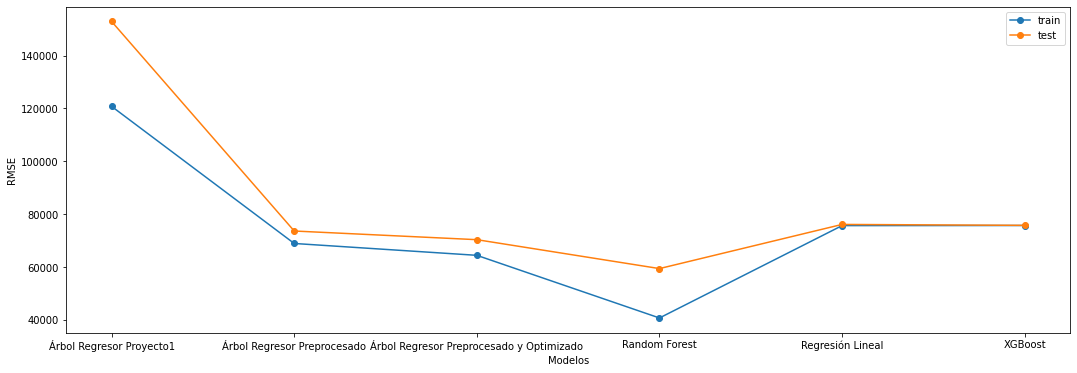

In [74]:
plt.figure(figsize=(18, 6))
plt.plot(Historial_de_errores.Modelo, Historial_de_errores.Train,'o-',label='train')
plt.plot(Historial_de_errores.Modelo, Historial_de_errores.Test,'o-',label='test')
plt.legend()
plt.xlabel('Modelos')
plt.ylabel('RMSE')

Como se observa en el gráfico vemos que el menor error en test lo tiene Random Forest, pero al tener una varianza bastante alta vamos a tomar como mejor modelo nuestro Árbol Regresor Preprocesado y Optimizado ya que tiene un error bajo y su varianza es pequeña respecto de los datos de entrenamiento. 

## Conclusión Final

¿qué podemos aprender de nuestro problema estudiando el modelo que generamos?

En este desarrollo pudimos ver que un buen preprocesamiento de datos es fundamental para no encontrarnos con resultados basura y es lo que hace de nuestro modelo un buen modelo.
Con respecto al modelo realizado en el primer proyecto el error bajó notablemente gracias a esto mismo, y continuó bajando cuando optimizamos los hiperparametros. 
Para poder seguir disminuyendo el error se podría implementar técnicas de clustering en nuestro preprocesamiento y así poder visualizar si los clusters son representativos. 

